In [1]:
"""this notebook based on https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py"""

import keras
from keras.models import Model
from keras.layers import Dense, Input, Activation, Lambda
from keras import objectives
import keras.backend as K
from scipy.stats import norm
import numpy as np
from keras.datasets import cifar10 

from matplotlib import pyplot as plt
%matplotlib inline

Using Theano backend.


In [2]:
(X_train, _), (X_test, y_test) = cifar10.load_data()

In [3]:
im_shape = X_train[0].shape
input_dim = np.prod(im_shape)
hidden_dim = 1000
batch_size = 500
z_dim = 2
nb_epoch = 50

In [4]:
X_train = X_train.astype('float32').reshape(X_train.shape[0], input_dim)/255
X_test = X_test.astype('float32').reshape(X_test.shape[0], input_dim)/255

In [5]:
x = Input(batch_shape=(batch_size, input_dim))
h = Dense(hidden_dim, activation="relu")(x)
z_mean = Dense(z_dim)(h)
z_log_var = Dense(z_dim)(h)

In [6]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, z_dim), mean=0.,
                              std=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [7]:
z = Lambda(sampling, output_shape=(z_dim,))([z_mean, z_log_var])

In [8]:
decoder_h = Dense(hidden_dim, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [9]:
vae = Model(input=x, output=x_decoded_mean)

In [10]:
def vae_loss(x, x_decoded_mean):
    xent_loss = input_dim * objectives.binary_crossentropy(x, x_decoded_mean) # binary_crossが平均値とるため
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

In [11]:
vae.compile(optimizer='adam', loss=vae_loss)

In [12]:
# vae.fit(X_train, X_train,
vae.fit(X_train, X_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(X_test, X_test))


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 2s - loss: 2057.4471 - val_loss: 2000.6220
Epoch 2/50
50000/50000 [==============================] - 2s - loss: 1987.1357 - val_loss: 2030.7252
Epoch 3/50
50000/50000 [==============================] - 2s - loss: 1968.5716 - val_loss: 1965.1632
Epoch 4/50
50000/50000 [==============================] - 2s - loss: 1964.3546 - val_loss: 1963.6885
Epoch 5/50
50000/50000 [==============================] - 2s - loss: 1962.4510 - val_loss: 1962.9403
Epoch 6/50
50000/50000 [==============================] - 2s - loss: 1961.8911 - val_loss: 1964.1319
Epoch 7/50
50000/50000 [==============================] - 2s - loss: 1960.4952 - val_loss: 1976.1019
Epoch 8/50
50000/50000 [==============================] - 2s - loss: 1960.0345 - val_loss: 1962.7672
Epoch 9/50
50000/50000 [==============================] - 2s - loss: 1960.4462 - val_loss: 1962.4271
Epoch 10/50
50000/50000 [================

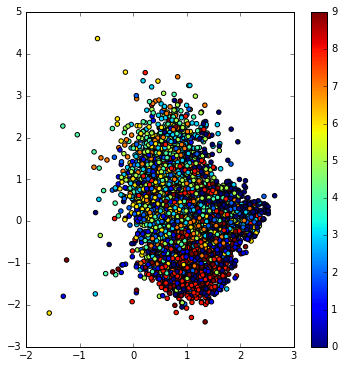

In [13]:
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.savefig('cifar_vae_mean.pdf')
plt.show()

In [14]:
decoder_input = Input(shape=(z_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [15]:
# display a 2D manifold of the digits
n = 10  # figure with 15x15 digits
digit_size = 32
nb_color = 3
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.01, 0.99, n))
grid_y = norm.ppf(np.linspace(0.01, 0.99, n))

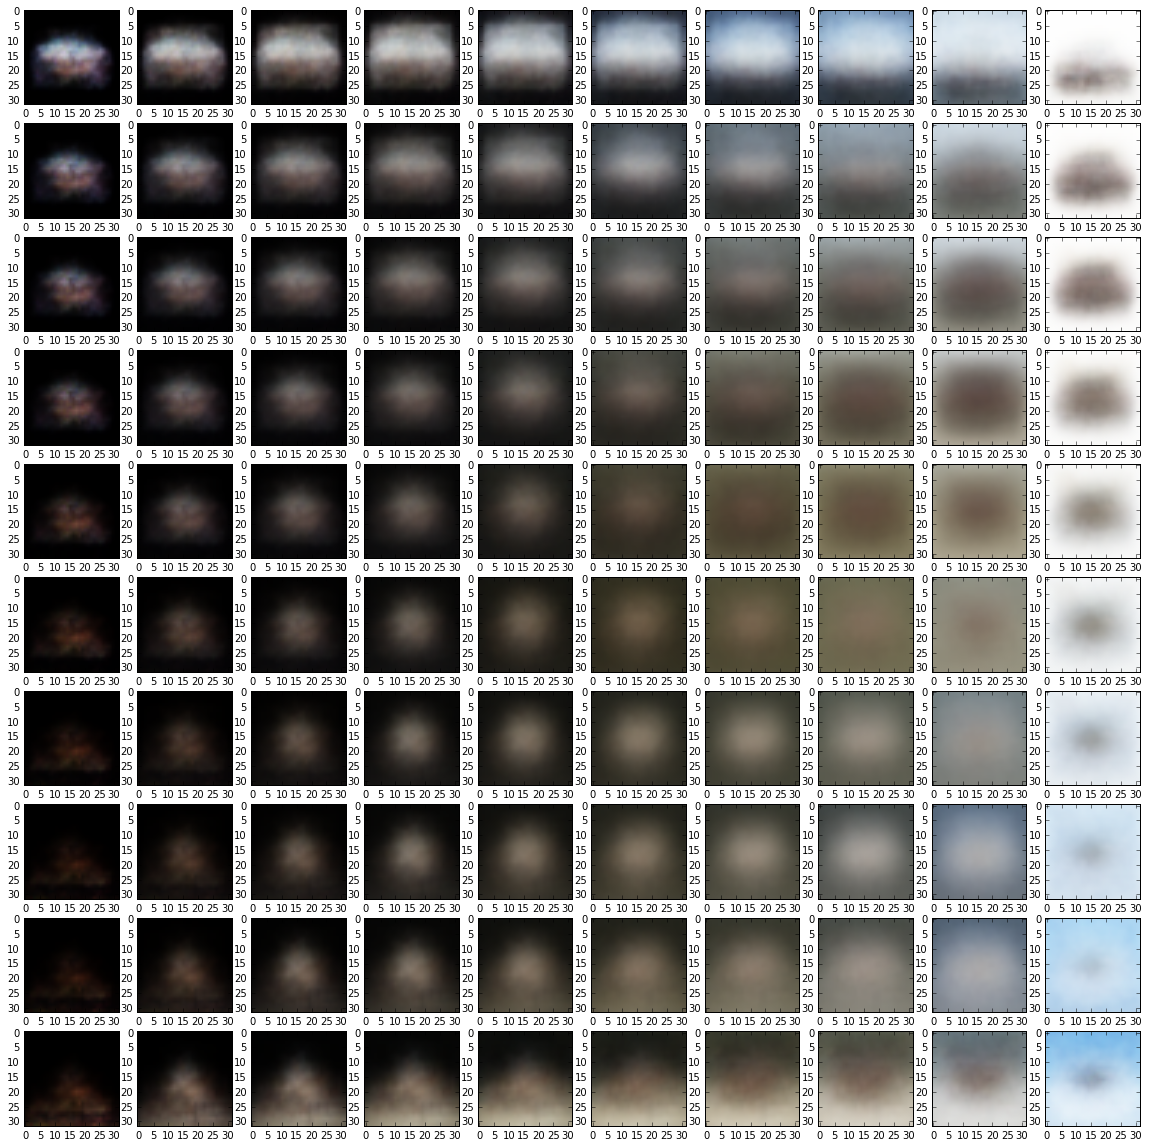

In [16]:
plt.figure(figsize=(20,20))
total = 1
for yi in grid_x:
    for xi in grid_y:
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        image = x_decoded[0].reshape(im_shape)
        plt.subplot(n, n, total)
        plt.imshow(image.transpose(1, 2, 0))
        total += 1

plt.savefig('cifar_vae_dist.pdf')
plt.show()